In [ ]:
%matplotlib inline
from jax.config import config
config.update("jax_enable_x64", True)  #important for L-BFGS

import jax
import jax.numpy as np

import matplotlib.pyplot as plt
import os
import numpy as onp
import pandas as pd

import scipy
import time

# for reproducibility of results
random_state = 3101
onp.random.seed(random_state)

data = pd.read_csv("../data/DSA3101_Hackathon_Data.csv", parse_dates=[1])
# data = pd.read_csv("/content/drive/My Drive/data/DSA3101_Hackathon_Data.csv", parse_dates=[1])
data['Volume'] = onp.where(data['Category']=='Eggs', data['Volume']*0.06, data['Volume'])    # eggs weigh around 60g
data['Volume'] = onp.where(data['Category']=='Instant Noodles', data['Volume']*0.06, data['Volume'])    # coincidentally instant noodles also weigh around 60g
data = data[(data.Volume != 0) & (data.Spend != 0) & (data['Pack Size'] != 0)].sort_values('Date')
data['Ratio'] = round(data.Spend/data.Volume, 2)
data['Product'] = data["Category"] + "_" + data["Ratio"].astype(str)
data.head()

,Panel ID,Date,Category,Pack Size,Volume,Spend,Ratio,Product
158373,Panel 152046101,2017-06-25,Sugar,1,1.00,3.0,3.00,Sugar_3.0
950580,Panel 800114201,2017-06-25,Sugar,1,1.00,3.0,3.00,Sugar_3.0
473559,Panel 240035101,2017-06-25,Eggs,1,0.36,5.3,14.72,Eggs_14.72
473560,Panel 240035101,2017-06-25,Liquid Milk,1,0.20,2.3,11.50,Liquid Milk_11.5
473561,Panel 240035101,2017-06-25,Canned Product,1,0.20,8.5,42.50,Canned Product_42.5


In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
data['Week'] = le.fit_transform(data.Date)
data.head()
# data.to_csv("/content/drive/My Drive/data/data.csv", index=False)
# data.to_csv("../data/data.csv", index=False)

In [ ]:
num_product = len(data.Product.unique())
num_panel = len(data['Panel ID'].unique())
print(f"Number of Product:{num_product} \t Number of Panels:{num_panel}")

Number of Product:36237 	 Number of Panels:3236


In [ ]:
%%time

# def EMA(x):
#   lst = x.shift(-1)-x
#   return lst.ewm(com=1).mean().tail(1).values

# def mean_spend(x):
#   pass

# x = data.groupby(by=["Panel ID", "Product"]).agg({
#     'Week': ['min', 'max', EMA], 'Spend': 'mean'}).reset_index()    # , 'Date': lambda x: len(x)
# x.columns = ['Panel ID', 'Product', 'min_week', 'max_week', 'EMA', 'mean_spend']
# x.fillna(0, inplace=True)
# x['Recency'] = x.max_week/156
# x['Frequency'] = (x.max_week - x.min_week - x.EMA)/(x.max_week - x.min_week)
# x['Monetary'] = x.mean_spend
# x.fillna(0, inplace=True)
# x['RFM'] = x['Recency']*10 + x['Frequency'] + x['Monetary']/200

# x.to_csv("/content/drive/My Drive/data/ratings.csv")
# x.to_csv("../data/ratings.csv")

CPU times: user 8min 22s, sys: 1.7 s, total: 8min 23s
Wall time: 8min 26s


In [ ]:
# x = pd.read_csv("/content/drive/My Drive/data/ratings.csv")
x = pd.read_csv("../data/ratings.csv")
x.RFM.min(), x.RFM.max()

(0.0035, 13.933743589743589)

In [ ]:
from sklearn.model_selection import train_test_split

X = x.loc[:,['Panel ID', 'Product']]
y = x.RFM
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=random_state, stratify=df['Panel ID'])

# # sanity check to ensure that the split is stratified
# X_train['Panel ID'].value_counts()

In [ ]:
# add rating column to train and test dataframe
train = X.assign(rating=y.values)
# train = X_train.assign(rating=y_train.values)
# test = X_test.assign(rating=y_test.values)
pivot = train.pivot_table(index='Panel ID', columns='Product', values='rating')
global_mean = onp.nanmean(pivot)
subset = onp.where(onp.isfinite(pivot.values))
pivot

Product,Baby Cereal_102.0,Baby Cereal_11.0,Baby Cereal_113.9,Baby Cereal_12.0,Baby Cereal_12.67,Baby Cereal_13.6,Baby Cereal_134.5,Baby Cereal_14.0,Baby Cereal_14.2,Baby Cereal_14.5,Baby Cereal_15.0,Baby Cereal_15.8,Baby Cereal_152.0,Baby Cereal_16.0,Baby Cereal_16.6,Baby Cereal_169.0,Baby Cereal_17.65,Baby Cereal_17.67,Baby Cereal_17.8,Baby Cereal_18.0,Baby Cereal_18.33,Baby Cereal_18.6,Baby Cereal_18.8,Baby Cereal_18.83,Baby Cereal_19.0,Baby Cereal_19.2,Baby Cereal_19.8,Baby Cereal_19.83,Baby Cereal_20.0,Baby Cereal_20.2,Baby Cereal_20.29,Baby Cereal_20.33,Baby Cereal_20.6,Baby Cereal_20.75,Baby Cereal_20.8,Baby Cereal_20.9,Baby Cereal_20.91,Baby Cereal_21.0,Baby Cereal_21.18,Baby Cereal_21.2,...,Yoghurts_8.62,Yoghurts_8.67,Yoghurts_8.71,Yoghurts_8.73,Yoghurts_8.75,Yoghurts_8.78,Yoghurts_8.8,Yoghurts_8.82,Yoghurts_8.83,Yoghurts_8.89,Yoghurts_8.91,Yoghurts_8.93,Yoghurts_80.0,Yoghurts_9.0,Yoghurts_9.08,Yoghurts_9.09,Yoghurts_9.11,Yoghurts_9.14,Yoghurts_9.17,Yoghurts_9.2,Yoghurts_9.23,Yoghurts_9.25,Yoghurts_9.29,Yoghurts_9.3,Yoghurts_9.33,Yoghurts_9.4,Yoghurts_9.43,Yoghurts_9.5,Yoghurts_9.6,Yoghurts_9.62,Yoghurts_9.67,Yoghurts_9.71,Yoghurts_9.75,Yoghurts_9.78,Yoghurts_9.8,Yoghurts_9.83,Yoghurts_9.87,Yoghurts_9.9,Yoghurts_9.93,Yoghurts_9.96
Panel ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Panel 101011101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Panel 101016101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Panel 101019101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Panel 101024101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Panel 105009103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Panel 801900701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Panel 801901201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [ ]:
# print(train.shape[0])
# print(f"Sparsity: {train.shape[0]/(35590*3236)}")

666665
Sparsity: 0.005788568197549971


In [ ]:
%%time
# naive models
def naive(x):
    if x == 'global mean':
        return onp.sqrt(onp.sum((train.rating.values - global_mean)**2) / train.shape[0])
        # return onp.sqrt(onp.sum((test.rating.values - global_mean)**2) / test.shape[0])
    cost = 0
    if x == 'panel mean':
        df = pd.DataFrame({'Panel ID': onp.sort(train['Panel ID'].unique()), 
                           'panel_mean': onp.nanmean(pivot, 1)})
        df = train.merge(df, how="left", on="Panel ID")
        # df = test.merge(df, how="left", on="Panel ID")
        cost += onp.sum((df.rating - df.panel_mean)**2)
    elif x == 'product mean':
        df = pd.DataFrame({'Product': onp.sort(train['Product'].unique()), 
                           'product_mean': onp.nanmean(pivot, 0)})
        df = train.merge(df, how="left", on="Product")
        # df = test.merge(df, how="left", on="Category")
        cost += onp.sum((df.rating - df.product_mean)**2)
    return np.sqrt(cost/train.shape[0])

# Using global mean
naive_global_mean = naive('global mean')
print('RMSE using global mean:', naive_global_mean)
      
# Using Panel mean
naive_panel_mean = naive('panel mean')
print('RMSE using Panel mean:', naive_panel_mean)

# Using Category mean
naive_product_mean = naive('product mean')
print('RMSE using Product mean:', naive_product_mean)

RMSE using global mean: 3.0538342370904434
RMSE using Panel mean: 2.7358987726798576
RMSE using Product mean: 2.86319097025174
CPU times: user 1.76 s, sys: 251 ms, total: 2.01 s
Wall time: 2.67 s


In [ ]:
%%time
# number of factors (latent variables)
d = 3

# start optimisation from this
U_init = onp.random.normal(onp.sqrt(global_mean/d), scale=1/onp.sqrt(num_panel*d), size=(num_panel, d))
V_init = onp.random.normal(onp.sqrt(global_mean/d), scale=1/onp.sqrt(num_product*d), size=(num_product, d))
# U_init = onp.random.poisson(int((global_mean/(d**2))**0.5), size=(num_panel, d))
# V_init = onp.random.poisson(int((global_mean/(d**2))**0.5), size=(num_product, d))
print("global mean:{0:.5f} \t minimum entry of U_init@V_init.T:{1:.5f} \t maximum entry of U_init@V_init.T:{2:.5f}".format(
    global_mean, onp.min(U_init@V_init.T), onp.max(U_init@V_init.T)))

def loss(U,V, reg = 0):
    cost = np.sum((pivot.values[subset] - (U @ V.T)[subset])**2)
    return cost/train.shape[0] + reg/num_panel*np.linalg.norm(U)**2 + reg/num_product*np.linalg.norm(V)**2

def RMSE(df, U, V, reg=False):
    cost = 0.
    panel_df = data_df['Panel ID'].unique()
    panel_df.sort()
    product_df = data_df['Product'].unique()
    product_df.sort()
    for pa, pr, r in df.values:
        # cost += (r - max(0, min(155, (U[panel_df==p] @ V[cat_df==c].T).ravel())))**2    # keep rating values within 0 and 155
        cost += (r - (U[panel_df==pa] @ V[product_df==pr].T).ravel())**2
    if reg:
        return np.sqrt(cost/df.shape[0]) + reg/num_panel*np.linalg.norm(U)**2 + reg/num_product*np.linalg.norm(V)**2
    else:
        return np.sqrt(cost/df.shape[0])

grad_loss_u = jax.jit(jax.grad(loss, argnums=0))
grad_loss_v = jax.jit(jax.grad(loss, argnums=1))

global mean:5.50028 	 minimum entry of U_init@V_init.T:5.38788 	 maximum entry of U_init@V_init.T:5.63184
CPU times: user 915 ms, sys: 156 ms, total: 1.07 s
Wall time: 554 ms


iter: 0 - time: 40.9380316734314 - loss: 6.602355234038489
iter: 1 - time: 75.94012188911438 - loss: 6.1082951508760495
iter: 2 - time: 110.46872115135193 - loss: 6.044093549578427
iter: 3 - time: 146.14276385307312 - loss: 6.011940710261863
iter: 4 - time: 181.3020794391632 - loss: 5.992801554552751
iter: 5 - time: 217.14736080169678 - loss: 5.979727671143764
iter: 6 - time: 252.35751104354858 - loss: 5.970720809237049
iter: 7 - time: 287.7225227355957 - loss: 5.9639527370341625
iter: 8 - time: 323.77890849113464 - loss: 5.958653430442342
iter: 9 - time: 359.73613834381104 - loss: 5.9543442248801215
CPU times: user 8min 48s, sys: 2min 41s, total: 11min 29s
Wall time: 5min 59s


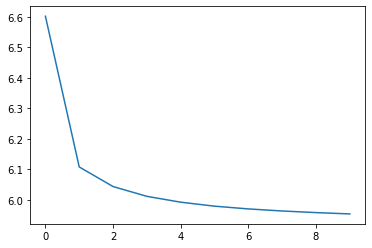

In [ ]:
%%time
#let us define a function that does a few steps of LBFGS with U fixed
#note that LBFGS expects vectors, not matrices --> we have to flatten everything
def minimize_U_fixed(U,V, LBFGS_iter):
    def grad_v_wrapper(V_flat):
        V = V_flat.reshape(num_product, d)
        return onp.array(grad_loss_v(U,V)).ravel()
    
    def loss_wrapper(V_flat):
        V = V_flat.reshape(num_product, d)
        return loss(U,V)
    
    traj = scipy.optimize.minimize(fun = loss_wrapper, #function to minimize
                                x0 = onp.array(V.ravel()), #initial guess
                                method='L-BFGS-B',  #we want to use L-BFGS
                                jac=grad_v_wrapper, #function that computes the gradient
                                options={"maxiter":LBFGS_iter})  #maximum number of iteration
    
    V_final = traj["x"].reshape(num_product, d)
    return V_final


#let us define a function that does a few steps of LBFGS with V fixed
def minimize_V_fixed(U,V, LBFGS_iter):
    def grad_v_wrapper(U_flat):
        U = U_flat.reshape(num_panel,d)
        return onp.array(grad_loss_u(U,V)).ravel()
    
    def loss_wrapper(U_flat):
        U = U_flat.reshape(num_panel,d)
        return loss(U,V)
    
    traj = scipy.optimize.minimize(fun = loss_wrapper, #function to minimize
                                x0 = onp.array(U.ravel()), #initial guess
                                method='L-BFGS-B',  #we want to use L-BFGS
                                jac=grad_v_wrapper, #function that computes the gradient
                                options={"maxiter":LBFGS_iter})  #maximum number of iteration
    U_final = traj["x"].reshape(num_panel,d)
    return U_final

U,V = onp.copy(U_init), onp.copy(V_init)
LBFGS_iter = 50
n_iter = 10
loss_history_train = []
start = time.time()

for _ in range(n_iter):
    V = minimize_U_fixed(U,V, LBFGS_iter)
    U = minimize_V_fixed(U,V, LBFGS_iter)
    loss_val = loss(U,V)
    loss_history_train.append(loss_val)
    print(f"iter: {_} - time: {time.time()-start} - loss: {loss_val}")

# gradient descent plot
plt.plot(loss_history_train)

In [ ]:
loss(U, V, 0)**0.5

DeviceArray(2.4401525, dtype=float64)

In [ ]:
%%time
# error = RMSE(train, U, V)
# print(f"RMSE(train): {round(error, 3)}")

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 10.7 µs


In [ ]:
%%time
# print(f"Improvement from Worst Naive Model (Using Global Mean) by {round(100*(1 - error/naive_global_mean), 1)}%")
# print(f"Improvement from Best Naive Model (Using Panel Mean) by {round(100*(1 - error/naive_panel_mean), 1)}%")

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [ ]:
user_df = pd.DataFrame(U, columns=[f"X{i}" for i in range(1, d+1)], index=pivot.index)
user_df.to_csv("../models/U.csv")
# user_df.to_csv("/content/drive/My Drive/models/U.csv")

In [ ]:
prod_df = pd.DataFrame(V, columns=[f"X{i}" for i in range(1, d+1)], index=pivot.columns)
# prod_df.to_csv("/content/drive/My Drive/models/V.csv")
prod_df.to_csv("../models/V.csv")
prod_df = prod_df.reset_index()

In [ ]:
product_df = prod_df.merge(data[['Category', 'Product']], how='left', on='Product')
product_df.head()

,Product,X1,X2,X3,Category
0,Baby Cereal_102.0,1.164440,1.373033,1.290461,Baby Cereal
1,Baby Cereal_11.0,1.639194,1.644311,1.688718,Baby Cereal
2,Baby Cereal_113.9,0.844231,0.892768,1.109718,Baby Cereal
3,Baby Cereal_12.0,2.096827,2.369931,2.151113,Baby Cereal
4,Baby Cereal_12.67,1.906856,1.794824,1.891373,Baby Cereal
